# Modèle Linéaire Régularisé & Validation Croisée

1. **Principe de la Régularisation**
    1. Pourquoi régulariser?
    2. Comment pénaliser le sur-apprentissage d'un modèle?
        1. Lasso (L1)
        2. Ridge (L2)
2. **La validation croisée**
    1. Principe de la validation croisée
    2. Recherche des meilleurs hyperparamètres de régularisation / Implémentation en python sous sklearn
3. **Conclusions**

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from numpy import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

In [2]:
from make_data import make_data_simple, make_data_mult_quantitative, make_data_intercept, make_data_slope, make_data_reg

## 1. Principe et Application

### La **régularisation** d'un modèle c'est quoi?
#### C'est une méthode qui permettent à un modèle de **ne pas sur-apprendre** le bruit présent dans les données d'entrainement.
#### Elle permet au modèle de mieux **généraliser**, c'est dire de faire de meilleurs prédictions sur des données qu'il n'a jamais vu.
#### En fait, la régularisation pénalise l'apprentissage du modèle.
#### Comment trouver la bonne dose? Comment 'séparer' le bruit de ce qui ne l'est pas?
#### C'est là que la validation croisée intervient, pour trouver cette bonne dose de pénalisation qui permettra à notre modèle de trouver la balance optimale entre performance de prédiction et généralisation. 

#### Mettons cela en pratique et ouvrons le dataset

In [3]:
#df = make_data_reg()
df = pd.read_csv('data_poly.csv')

#### Regardons les premières lignes de la table (pandas.DataFrame)

In [4]:
df.head()

,x,y
0,85.000000,380.000000
1,75.000000,360.101569
2,70.607509,275.121225
3,112.000000,457.661218
4,120.195292,506.531438


#### Regardons les dimensions de la table

In [5]:
df.shape

(30, 2)

#### On divise la table en deux parties inégales, 66% des données pour l'entrainement et 33% pour le test
#### On utilise généralement 80% des données pour l'entrainement et 20% pour le test, mais ce n'est pas une règle fixe, il faut faire preuve de bon sens, s'adapter en fonction du contexte
#### On peut utiliser la méthode train_test_split de sklearn
#### Nous suivons les étapes suivantes pour l'entrainement d'un modèle de régression et pour évaluer si il **généralise** bien sur des données de test:
1. on sépare les variables explicatives (features >>> un dataframe ou array nommé X) de la variable à prédire (target >>> un dataframe ou array nommé y)
2. on rajoute une colonne avec une constante = 1, afin de permettre de calculer le paramètre de l'ordonnée à l'origine (e.g. intercept) 
3. on divise les données en deux parties, les données d'entrainement et les données de test
4. on crée une instance de la classe du modèle (ex: model = LinearRegression() pour une régression linéaire), on dit qu'on **initialise** le modèle
5. on ajuste (fit) le modèle avec les données d'entrainement (ex: model.fit(X_train, y_train))
6. on évalue l'erreur produite par le modèle sur les données d'entrainement et de test en utilisant le coéfficient de détermination R2 (ex: model.score(X_train, y_train); model.score(X_test, y_test)) et on compare la différence, si il n'y a pas de différence entre les R2 (train et test) le modèle généralise bien, et c'est cela que l'on cherche
7. on fait les vérifications vues dans le cours sur la régression linéaire (tracer la courbe du modèle sur les données, observed vs predicted, distribution des résidues, etc...)
8. on valide ou pas, on améliore, etc...

In [6]:
#d'abord on sépare les variables explicatives de la variable à prédire
X = df[['x']]
y = df[['y']]
#on ajoute une colonne de 1 pour l'intercept (constant)
X['constant'] = 1
#on divise les données en deux parties, les données d'entrainement et les données de test avec les proportions 66%-33%, sur les indexes pour le moment
#on pourra utiliser la méthode train_test_split de sklearn (ligne de code commenté en bas de la cellule)
def make_train_test_data(X, y):
    X_train = X.iloc[0:20]
    X_test = X.iloc[20:].reset_index(drop=True)
    y_train = y.iloc[0:20]
    y_test = y.iloc[20:].reset_index(drop=True)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = make_train_test_data(X, y)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

#### Regardons les données d'entrainement

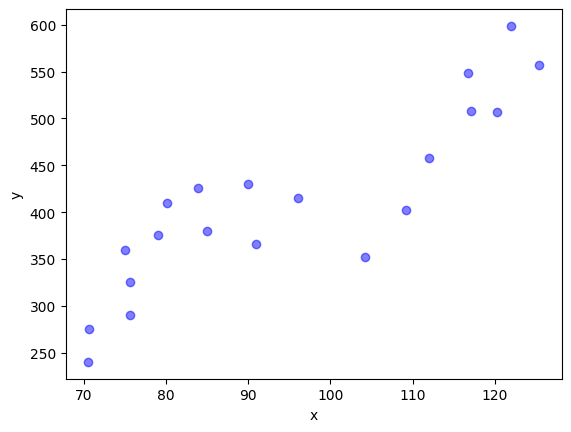

In [7]:
#regardons les données d'entrainement
plt.scatter(X_train['x'], y_train['y'], label='train', alpha=0.5, c='b')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### Essayons d'ajuster un modèle linéaire simple avec une pente et une intercept sur ces données d'entrainement 

In [8]:
#entrainons un modéle linéaire sur les données d'entrainement
#on crée un objet de la classe LinearRegression, on initialise le modèle
model = LinearRegression()
#on entraine le modèle sur les données d'entrainement
model.fit(X_train, y_train)
#ajoutons les prédictions du modèle à nos dataframe de training et de test
y_train['pred'] = model.predict(X_train)
y_test['pred'] = model.predict(X_test)
#calculons le coefficient de détermination R2 avec la méthode .score
R2_train = model.score(X_train, y_train['y'])
R2_test = model.score(X_test, y_test['y'])
print(f'Le R2 score de d\'entrainement est de {round(R2_train,2)}')
print(f'Le R2 score de test est de {round(R2_test,2)}')

Le R2 score de d'entrainement est de 0.76
Le R2 score de test est de 0.62


#### On voit que le R2 est meilleur sur les données d'entrainement (train:  R2 = 0,76) que pour les données de test (R2 = 0.62)

In [9]:
# j'ai ici codé une fonction afin de faciliter la création de courbe de prédiction, elle prend en argument le modèle et les données X
def make_curve(model, X):
    #on recupère les valeurs min et max de x pour créer une courbe de prédiction dans cet intervalle
    x_min = X['x'].min()
    x_max = X['x'].max()
    #on crée une liste de valeurs de x dans l'intervalle [x_min, x_max] par pas de 1
    x_curve = [i for i in range(int(x_min), int(x_max))]
    #on crée un dataframe avec ces valeurs
    df_curve = pd.DataFrame({'x': x_curve})
    #on ajoute une colonne de 1 pour l'intercept (constant), c'est nécessaire pour la prédiction, le dataframe doit avoir la même forme que celui sur lequel le modèle a été entrainé
    df_curve['constant'] = 1
    #on ajoute une colonne y_pred avec les prédictions du modèle et la méthode .predict
    df_curve['y_pred'] = model.predict(df_curve)
    #on retourne le dataframe
    return df_curve    

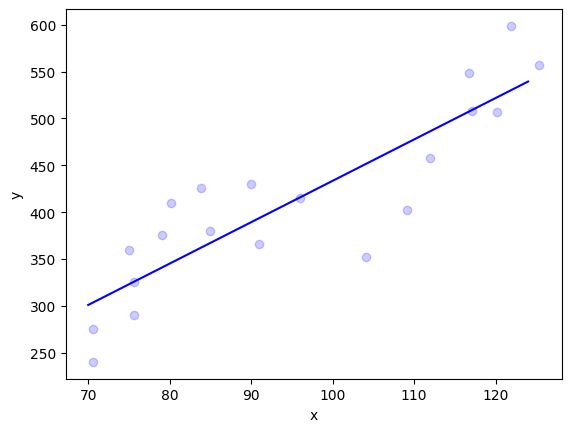

In [10]:
#on genère une courbe avec les prédictions du modèle
df_model_curve = make_curve(model, X_train)
#regardons les données d'entrainement sur un graphique
plt.scatter(X_train['x'], y_train['y'], label='train', alpha=0.2, c='b')
#regardons le modèle (la meilleur droite) sur un graphique
plt.plot(df_model_curve['x'], df_model_curve['y_pred'], label='train', c='b')
plt.xlabel('x')
plt.ylabel('y') 
plt.show()

#### Essayons un modèle quadratique (polynome du second degré), c'est la même chose sauf que l'on rajoute une colonne avec x^2

In [11]:
#on sélectionne 66% des données pour l'entrainement et 33% pour le test
#on peut utiliser la méthode train_test_split de sklearn
#d'abord on sépare les variables explicatives de la variable à prédire
X = df[['x']]
y = df[['y']]
#on ajoute une colonne de 1 pour l'intercept (constant)
X['constant'] = 1
#on rajoute un colonne x^2 pour le modèle polynomiale (quadratique)
X['x2'] = X['x']**2

X_train, X_test, y_train, y_test = make_train_test_data(X, y)

In [12]:
#entrainons un modéle linéaire sur les données d'entrainement
#on crée un objet de la classe LinearRegression, on initialise le modèle
model = LinearRegression()
#on entraine le modèle sur les données d'entrainement
model.fit(X_train, y_train)
#ajoutons les prédictions du modèle à nos dataframe de training et de test
y_train['pred'] = model.predict(X_train)
y_test['pred'] = model.predict(X_test)
#calculons le coefficient de détermination R2 avec la méthode .score
R2_train = model.score(X_train, y_train['y'])
R2_test = model.score(X_test, y_test['y'])
print(f'Le R2 score de d\'entrainement est de {R2_train}')
print(f'Le R2 score de test est de {R2_test}')

Le R2 score de d'entrainement est de 0.762717794159345
Le R2 score de test est de 0.6353273694512273


#### Là aussi on note que le R2 est meilleur sur les données d'entrainement (train:  R2 = 0,76) que pour les données de test (R2 = 0.63)

In [13]:
#on modifie la fonction make_curve pour qu'elle prenne en compte les données polynomiales
def make_curve(model, X):
    x_min = X['x'].min()
    x_max = X['x'].max()
    x_curve = [i for i in range(int(x_min), int(x_max))]
    df_curve = pd.DataFrame({'x': x_curve})
    df_curve['constant'] = 1
    df_curve['x2'] = df_curve['x']**2
    df_curve['y_pred'] = model.predict(df_curve)
    return df_curve    

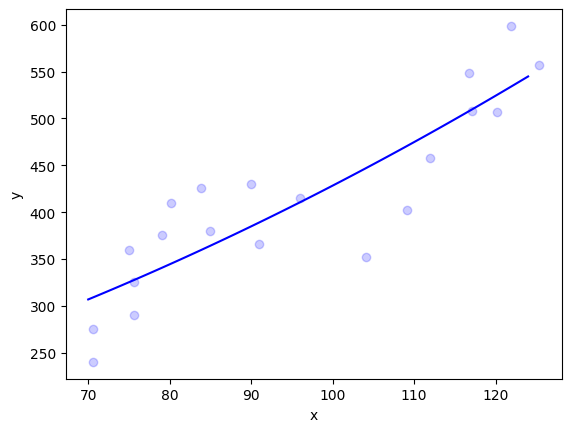

In [14]:
#on génère une courbe avec les prédictions du modèle
df_model_curve = make_curve(model, X_train)
#regardons les données d'entrainement et de test sur un graphique
plt.scatter(X_train['x'], y_train['y'], label='train', alpha=0.2, c='b')
#regardons les données d'entrainement et de test sur un graphique
plt.plot(df_model_curve['x'], df_model_curve['y_pred'], label='train', c='b')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### On voit que la droite est devenue courbe
#### Les données sont en forme de zigzag, comme des vagues, peut-être qu'un polynome plus complexe, avec plus de paramètres permettrait de mieux s'ajuster aux données.
#### Essayons avec un polynome du 5éme degré, il faut alors rajouter dans la table les colonne x^2, x^3, x^4, x^5, et la constante pour l'intercept

In [15]:
#on sélectionne de manière aléatoire 50% des données pour l'entrainement et 50% pour le test
#on peut utiliser la méthode train_test_split de sklearn
#d'abord on sépare les variables explicatives de la variable à prédire
X = df[['x']]
y = df[['y']]
#on ajoute une colonne de 1 pour l'intercept (constant)
X['constant'] = 1
#on rajoute un colonne x^2, x^3, x^4, x^5 pour un modèle polynomiale plus complexe
X['x2'] = X['x']**2
X['x3'] = X['x']**3
X['x4'] = X['x']**4
X['x5'] = X['x']**5
#on divise les données en deux parties, les données d'entrainement et les données de test avec les proportions 50%-50%
X_train, X_test, y_train, y_test = make_train_test_data(X, y)

In [16]:
X_train.head()

,x,constant,x2,x3,x4,x5
0,85.000000,1,7225.000000,6.141250e+05,5.220062e+07,4.437053e+09
1,75.000000,1,5625.000000,4.218750e+05,3.164062e+07,2.373047e+09
2,70.607509,1,4985.420336,3.520081e+05,2.485442e+07,1.754908e+09
3,112.000000,1,12544.000000,1.404928e+06,1.573519e+08,1.762342e+10
4,120.195292,1,14446.908118,1.736450e+06,2.087132e+08,2.508634e+10


In [17]:
#entrainons un modéle linéaire sur les données d'entrainement
#on crée un objet de la classe LinearRegression, on initialise le modèle
model = LinearRegression()
#on entraine le modèle sur les données d'entrainement
model.fit(X_train, y_train)
#ajoutons les prédictions du modèle à nos dataframe de training et de test
y_train['pred'] = model.predict(X_train)
y_test['pred'] = model.predict(X_test)
#calculons le coefficient de détermination R2 avec la méthode .score
R2_train = model.score(X_train, y_train['y'])
R2_test = model.score(X_test, y_test['y'])
print(f'Le R2 score de d\'entrainement est de {round(R2_train,2)}')
print(f'Le R2 score de test est de {round(R2_test,2)}')
#sauvegardons les paramètres du modèle
params_lm = model.coef_
intercept_lm = model.intercept_
score_lm_train = round(R2_train,2)
score_lm_test = round(R2_test,2)

Le R2 score de d'entrainement est de 0.92
Le R2 score de test est de 0.49


#### On note que le R2 est bien amélioré sur les données d'entrainement (R2 = 0,92) par rapport au modèle précédent (R2 = 0.76).
#### Néanmoins la qualité de la prédiction chute aussi considérablement sur les données de test (avant: R2 = 0.63, après = 0.49).
#### Conclusion: Plus on met de paramètres dans notre modèle, plus notre modèle sera capable de s'ajuster aux données, mais aussi sur-apprendre, au risque de ne pas bien généraliser sur les données qu'il n'a jamais vu.
#### On parle de "overfitting" en anglais.

In [18]:
#on modifie la fonction make_curve pour qu'elle prenne en compte les données polynomiales
def make_curve(model, X):
    x_min = X['x'].min()
    x_max = X['x'].max()
    x_curve = [i for i in range(int(x_min), int(x_max))]
    df_curve = pd.DataFrame({'x': x_curve})
    df_curve['constant'] = 1
    df_curve['x2'] = df_curve['x']**2
    df_curve['x3'] = df_curve['x']**3
    df_curve['x4'] = df_curve['x']**4
    df_curve['x5'] = df_curve['x']**5
    df_curve['y_pred'] = model.predict(df_curve)
    return df_curve    

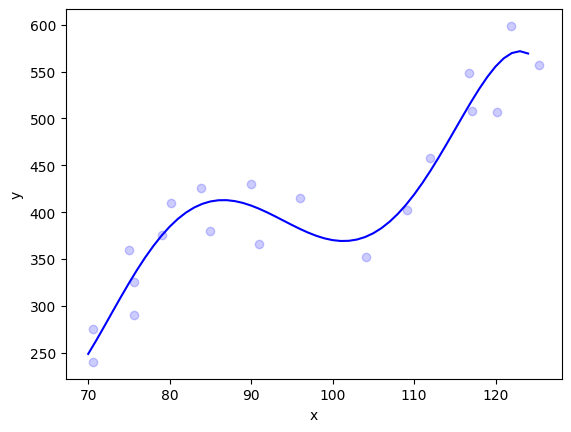

In [19]:
#on génère une courbe avec les prédictions du modèle
df_model_curve = make_curve(model, X_train)
#regardons les données d'entrainement et de test sur un graphique
plt.scatter(X_train['x'], y_train['y'], label='train', alpha=0.2, c='b')
#regardons les données d'entrainement et de test sur un graphique
plt.plot(df_model_curve['x'], df_model_curve['y_pred'], label='train', c='b')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### La courbe s'ajuste parfaitement aux données d'entrainement, c'est magnifique!

In [20]:
#### Courbe suit les données d'entrainement mais pas les données de test, overfitting

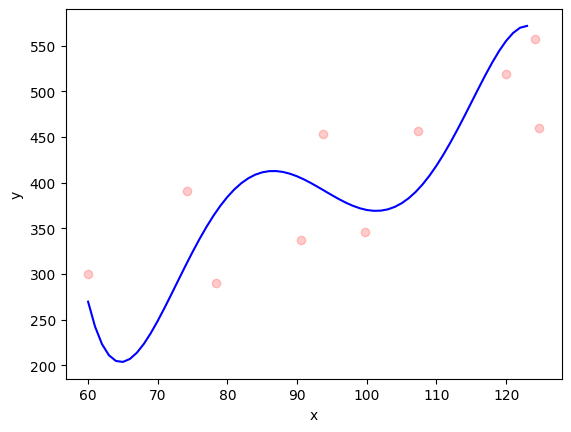

In [21]:
#on génère une courbe avec les prédictions du modèle
df_model_curve = make_curve(model, X_test)
#regardons les données d'entrainement et de test sur un graphique
plt.scatter(X_test['x'], y_test['y'], label='test', alpha=0.2, c='r')
#regardons les données d'entrainement et de test sur un graphique
plt.plot(df_model_curve['x'], df_model_curve['y_pred'], label='train', c='b')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### Mais ne s'ajuste pas du tout aux données de test, oops!

#### Comment éviter ce problème? 
#### Grâce à la régularisation.

# 1. **Principe de la Régularisation**
##    2. Comment pénaliser le sur-apprentissage d'un modèle?
###        1. Lasso (L1)

#### La stratégie est la suivante: si on veut pénaliser l'apprentissage du modèle, il faut empêcher les paramètres de trop s'ajuster, de devenir trop grands en somme. 


#### On implémente cela dans la fonction de coût, la MSE
#### Ci-dessous la formule de base de la MSE

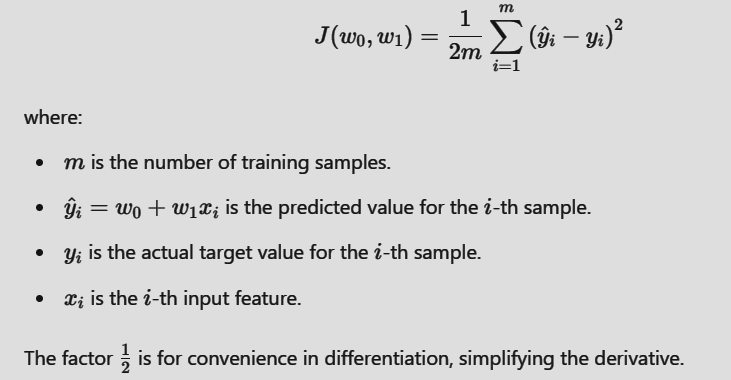

In [22]:
Image(filename='image/MSE.png')   

#### Maintenant, on rajoute ici le terme de régularisation (lambda dans la formule) qui multiple la somme des valeurs absolues des paramètres du modèle.
#### Etant donné que l'on veut minimiser cette fonction de coût pendant l'apprentissage (souvenez-vous la descente de gradient!), on trouvera une balance entre une erreur globale faible (MSE) et des paramètres prenant des valeurs faibles.
#### On peut ajuster la pénalité en fesant varier la terme de régularisation pour trouver la bonne balance entre pénalité et apprentissage. 

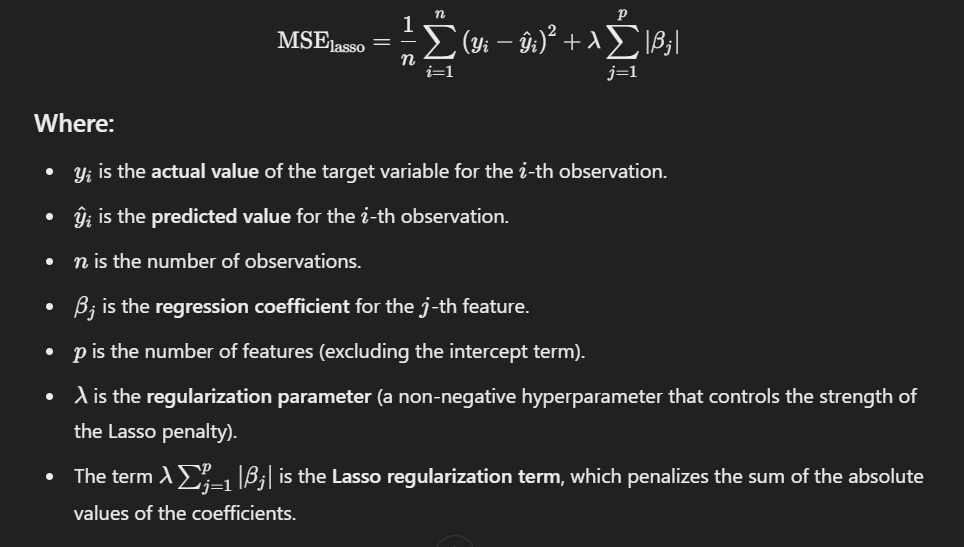

In [23]:
Image(filename='image/MSE_lasso.png')   

#### Regardons le modèle avec une régularisation Lasso, et le terme de régularisation (appelé dans sklearn alpha) égal à 1.

In [24]:
#entrainons un modéle linéaire sur les données d'entrainement
#on crée un objet de la classe Lasso, on initialise le modèle
lasso = Lasso(alpha=1)
#on entraine le modèle sur les données d'entrainement
lasso.fit(X_train, y_train[['y']])
#ajoutons les prédictions du modèle à nos dataframe de training et de test
y_train['pred_reg'] = lasso.predict(X_train)
#calculons le coefficient de détermination R2 avec la méthode .score
R2_train = lasso.score(X_train, y_train[['y']])
R2_test = lasso.score(X_test, y_test[['y']])
score_lasso_train = round(R2_train,2)
score_lasso_test = round(R2_test,2)
print(f'Le R2 score de d\'entrainement est de {round(R2_train,2)}')
print(f'Le R2 score de test est de {round(R2_test,2)}')

Le R2 score de d'entrainement est de 0.79
Le R2 score de test est de 0.59


#### On observe une différence moindre entre les R2 des données d'entrainement et de test:
#### Polynome non-régularisé: R2 train = 0.92 / R2 test = 0.49
#### Polynome régularisé: R2 train = 0.79 / R2 test = 0.59
#### Regardons cela sur une graphique.

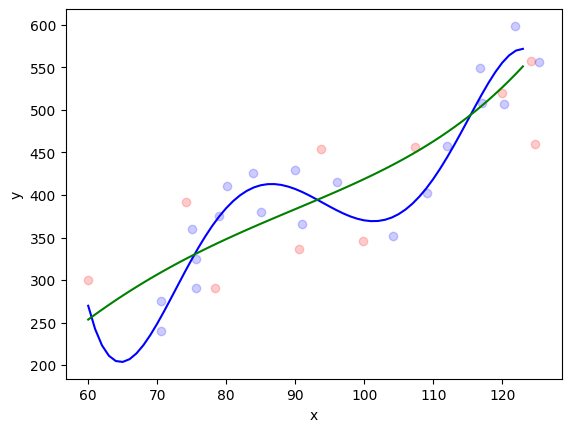

In [25]:
#on génère une courbe avec les prédictions du modèle
df_model_curve_regularized = make_curve(lasso, X_test)
#regardons les données d'entrainement et de test sur un graphique
plt.scatter(X_train['x'], y_train['y'], label='test', alpha=0.2, c='b')
plt.scatter(X_test['x'], y_test['y'], label='test', alpha=0.2, c='r')
#regardons les données d'entrainement et de test sur un graphique
plt.plot(df_model_curve['x'], df_model_curve['y_pred'], label='train', c='b')
plt.plot(df_model_curve_regularized['x'], df_model_curve_regularized['y_pred'], label='train', c='g')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### Le modèle s'est moins ajusté aux données d'entrainement mais généralise mieux sur les données de test.

#### Jouons un peu avec le paramètre de régularisation pour voir son effet. 

Text(0, 0.5, 'R2 score')

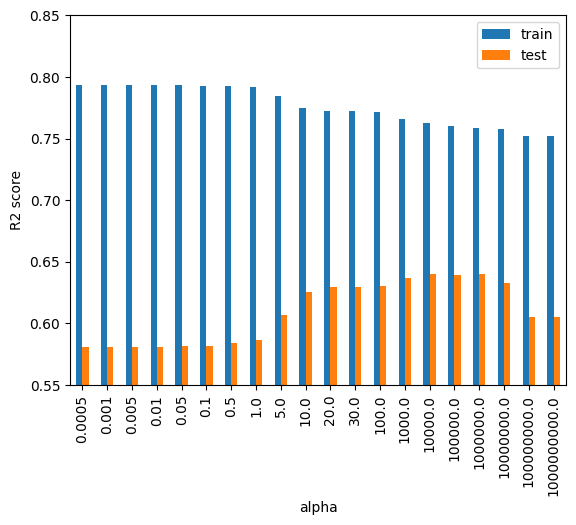

In [26]:
#regardons l'effet du paramètre alpha sur les scores du modèle (train et test R2)
#on crée une liste de valeurs de alpha
alphas = [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 30, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000]
#on crée une liste vide pour stocker les scores
scores_train = []
scores_test = []
#on boucle sur les valeurs de alpha
for alpha in alphas:
    #on crée un modèle Lasso avec la valeur de alpha
    lasso = Lasso(alpha=alpha)
    #on entraine le modèle sur les données d'entrainement
    lasso.fit(X_train, y_train[['y']])
    #on ajoute les scores du modèle à la liste
    scores_train.append(lasso.score(X_train, y_train[['y']]))
    scores_test.append(lasso.score(X_test, y_test[['y']]))
    
#on crée un dataframe avec les scores
df_scores = pd.DataFrame({'alpha': alphas, 'train': scores_train, 'test': scores_test})
#on crée un graphique avec les scores
df_scores.plot(x='alpha', y=['train', 'test'], kind='bar', ylim=(0.55, 0.85))
plt.xlabel('alpha')
plt.ylabel('R2 score')

#### Entre 0.0005 et 0.5, la régularisation n'a pas d'effet, mais ceci ne doit pas être pris comme règle générale, c'est ce que nous observons sur notre modèle, et avec nos données, en somme dans nos conditions.
#### Entre 0.5 et 10000, on voit que plus alpha augmente plus le R2 'train' diminu et plus le R2 'test' augmente, donc moins le modèle sur-apprend et mieux il généralise, et c'est ce que l'on veut.
#### Après alpha = 1000000 l'effet s'estompe, on devient délétère car le R2 sur les données de test diminue (ex: après 10000000)

#### Ré-entrainons le modèle avec alpha = 10

In [27]:
#réentrainons le modèle avec la valeur de alpha qui donne le meilleur score sur les données de test, ici 10
#on crée un objet de la classe LinearRegression, on initialise le modèle
lasso = Lasso(alpha=10)
#on entraine le modèle sur les données d'entrainement
lasso.fit(X_train, y_train[['y']])
#ajoutons les prédictions du modèle à nos dataframe de training et de test
y_train['pred_reg'] = lasso.predict(X_train)
#calculons le coefficient de détermination R2 avec la méthode .score
R2_train = lasso.score(X_train, y_train[['y']])
R2_test = lasso.score(X_test, y_test[['y']])
score_lasso_train = round(R2_train,2)
score_lasso_test = round(R2_test,2)
print(f'Le R2 score de d\'entrainement est de {round(R2_train,2)}')
print(f'Le R2 score de test est de {round(R2_test,2)}')

Le R2 score de d'entrainement est de 0.77
Le R2 score de test est de 0.63


#### Regardons la différences entre les paramètres du modèle avec et sans régularisation

Text(0, 0.5, 'log(abs(parameters value))')

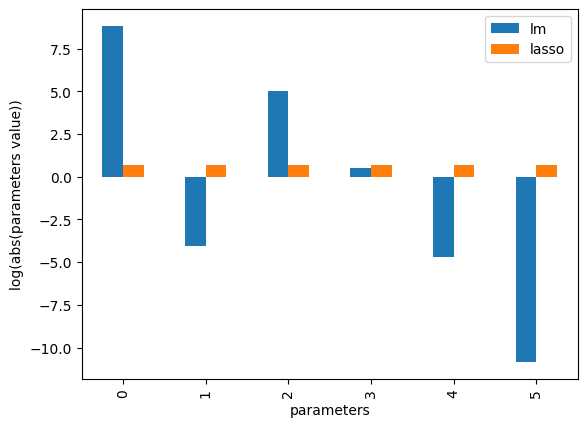

In [28]:
#comparons les paramètre du modèle linéaire et du modèle régularisé
params_lasso = lasso.coef_
intercept_lasso = lasso.intercept_
#on met les paramètres dans un dataframe
df_params = pd.DataFrame({'lm': params_lm[0], 'lasso': params_lasso[0]})
#on transforme les données en valeurs absolues pour les comparer et on les mets en échelle logarithmique
df_params = np.abs(df_params)
df_params = np.log(df_params)
#on fait un graphique pour comparer les paramètres
df_params.plot(kind='bar')
plt.xlabel('parameters')
plt.ylabel('log(abs(parameters value))')

#### On voit ici que les valeurs des paramètres sont plus homogènes avec la régulation, aucun n'a pris de valeurs extrèmes.

# 1. **Principe de la Régularisation**
##    2. Comment pénaliser le sur-apprentissage d'un modèle?
###        2. Ridge (L2)

#### Un autre type de régularisation existe, la régularisation Ridge, mais le principe est le même. 
#### La différence est que l'on considère ici la somme des paramètres au carré, et non pas la somme de leurs valeurs absolues (i.e. Lasso)

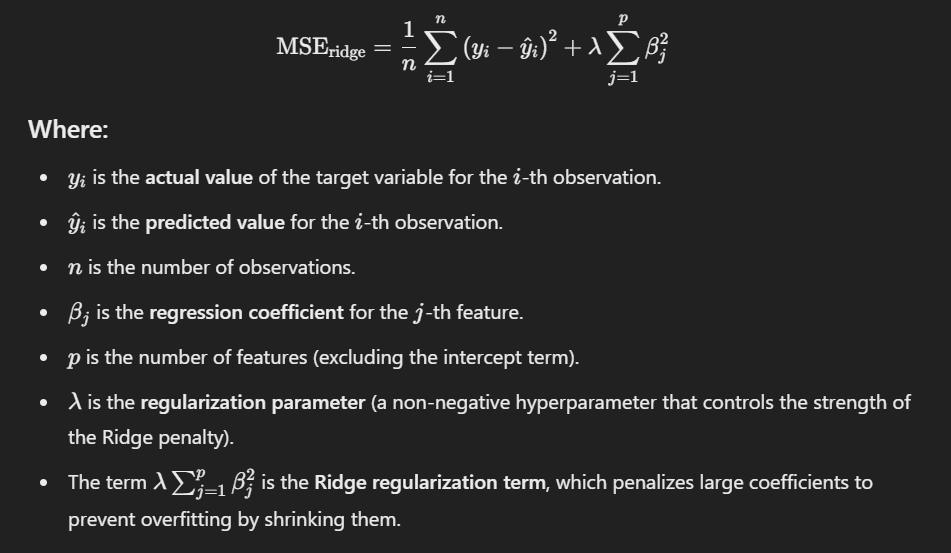

In [29]:
Image(filename='image/MSE_ridge.png')   

#### Jouons avec alpha

Text(0, 0.5, 'R2 score')

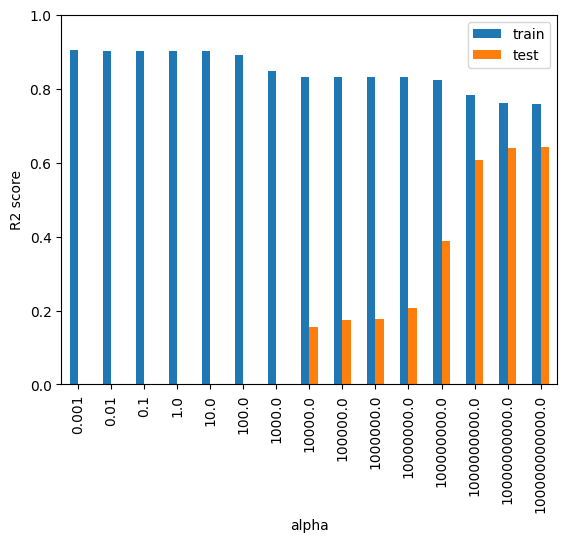

In [30]:
#regardons l'effet du paramètre alpha sur les scores du modèle (train et test R2)
#on crée une liste de valeurs de alpha
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000, 10000000000, 100000000000]
#on crée une liste vide pour stocker les scores
scores_train = []
scores_test = []
#on boucle sur les valeurs de alpha
for alpha in alphas:
    #on crée un modèle Lasso avec la valeur de alpha
    ridge = Ridge(alpha=alpha)
    #on entraine le modèle sur les données d'entrainement
    ridge.fit(X_train, y_train[['y']])
    #on ajoute les scores du modèle à la liste
    scores_train.append(ridge.score(X_train, y_train[['y']]))
    scores_test.append(ridge.score(X_test, y_test[['y']]))
    
#on crée un dataframe avec les scores
df_scores = pd.DataFrame({'alpha': alphas, 'train': scores_train, 'test': scores_test})
#on crée un graphique avec les scores
df_scores.plot(x='alpha', y=['train', 'test'], kind='bar', ylim=(0, 1))
plt.xlabel('alpha')
plt.ylabel('R2 score')

#### Entre 0.001 et 1000, la régularisation n'a pas d'effet, mais ceci ne doit pas être pris comme règle générale, comme dit préceddement.
#### Entre 10000 et 10000000000, on voit que plus alpha augmente plus le R2 'train' diminu et plus le R2 'test' augmente, donc moins le modèle sur-apprend et mieux il généralise, encore une fois c'est ce que l'on veut.
#### Après l'augmentation de la valeur alpha n'a plus d'effet.
#### Ré-entrainons le modèle avec alpha = 10000000000   

In [31]:
#entrainons un Ridge sur les données d'entrainement
#on crée un objet de la classe Ridge, on initialise le modèle
ridge = Ridge(alpha=10000000000)
#on entraine le modèle sur les données d'entrainement
ridge.fit(X_train, y_train[['y']])
#ajoutons les prédictions du modèle à nos dataframe de training et de test
y_train['pred_reg'] = ridge.predict(X_train)
#calculons le coefficient de détermination R2 avec la méthode .score
R2_train = ridge.score(X_train, y_train[['y']])
R2_test = ridge.score(X_test, y_test[['y']])
score_ridge_train = round(R2_train,2)
score_ridge_test = round(R2_test,2)
print(f'Le R2 score de d\'entrainement est de {round(R2_train,2)}')
print(f'Le R2 score de test est de {round(R2_test,2)}')

Le R2 score de d'entrainement est de 0.76
Le R2 score de test est de 0.64


#### On observe une différence moindre entre les R2 des données d'entrainement et de test:
#### Polynome non-régularisé: R2 train = 0.92 / R2 test = 0.49
#### Polynome régularisé: R2 train = 0.76 / R2 test = 0.64
#### Regardons cela sur une graphique.

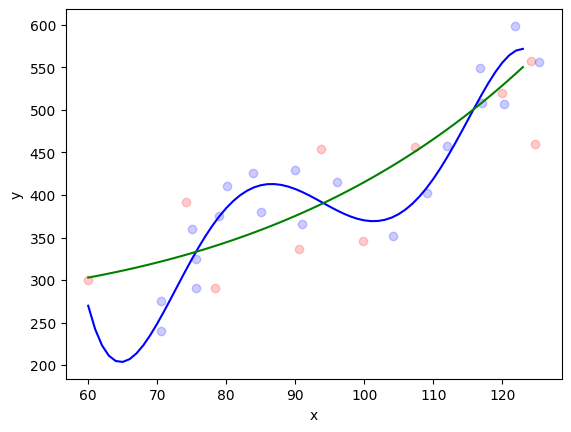

In [32]:
#on génère une courbe avec les prédictions du modèle
df_model_curve_regularized = make_curve(ridge, X_test)
#regardons les données d'entrainement et de test sur un graphique
plt.scatter(X_train['x'], y_train['y'], label='test', alpha=0.2, c='b')
plt.scatter(X_test['x'], y_test['y'], label='test', alpha=0.2, c='r')
#regardons les données d'entrainement et de test sur un graphique
plt.plot(df_model_curve['x'], df_model_curve['y_pred'], label='train', c='b')
plt.plot(df_model_curve_regularized['x'], df_model_curve_regularized['y_pred'], label='train', c='g')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### Il semble que l'on retrouve quelque chose qui ressemble à notre modèle quadratique dans la forme de la courbe.

Text(0, 0.5, 'log(abs(parameters value))')

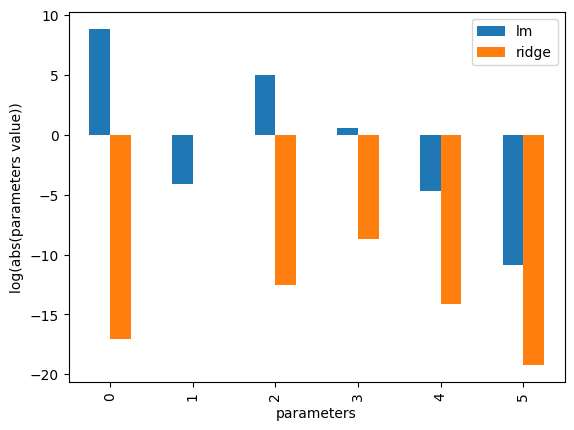

In [33]:
#comparons les paramètre du modèle linéaire et du modèle régularisé
params_ridge = ridge.coef_
intercept_ridge = ridge.intercept_
#on met les paramètres dans un dataframe
df_params = pd.DataFrame({'lm': params_lm[0], 'ridge': params_ridge[0]})
#on transforme les données en valeurs absolues pour les comparer et on les mets en échelle logarithmique
df_params = np.abs(df_params)
df_params = np.log(df_params)
#on fait un graphique pour comparer les paramètres
df_params.plot(kind='bar')
plt.xlabel('parameters')
plt.ylabel('log(abs(parameters value))')

#### Tout les paramètres ont été poussés à prendre des valeurs très faible car le paramètre alpha est extrêmement grand, donc la pénalisation est énorme.
#### Néanmoins cela fonctionne en pratique.
#### La régularisation ElasticNet permet de régulariser à la fois avec Lasso (L1) et Ridge (L2), pour une régularisation plus fine.

# 2. **La validation croisée**
##    1. Principe de la validation croisée

#### Comme nous venons de le voir, il faut trouver la bonne dose de régularisation afin d'ajuster au mieux le modèle mais aussi afin que celui-ci généralise au mieux sur des données qu'il n'a jamais vu.
#### La recherche des meilleurs paramètres de régularisation est entreprise par la méthode de la validation croisée
#### Elle se raprroche de ce que nous avons fait sur les données train et test, à la différence que l'opération est faite de multiples fois, sur le jeu de données d'entrainement (train), avant la comparaison faite avec les données de test.
#### Ci-dessous le schéma de l'approche générale.  

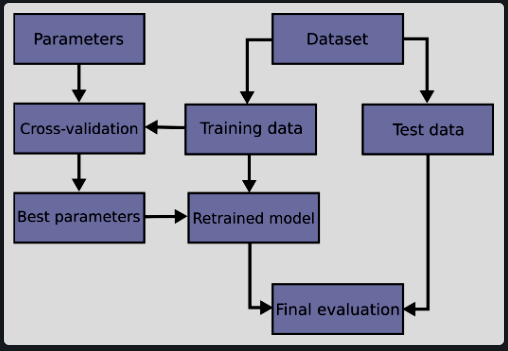

In [34]:
Image(filename='image/CV_overview.png')

#### L'idée de la validation croisée est de diviser le jeux de données de manière aléatoire en k parties (folds), on entraine le modèle sur k-1 folds et on teste sur le fold restant
#### On fait donc cette opération k fois, et on obtient en score la moyenne des scores (R2 test) pour un paramètre de régularisation données par exemple.
#### Le paramètre de régularisation est appelé hyperparamètre du modèle.
#### C'est ainsi qu'on trouve notre valeur de alpha optimale.  

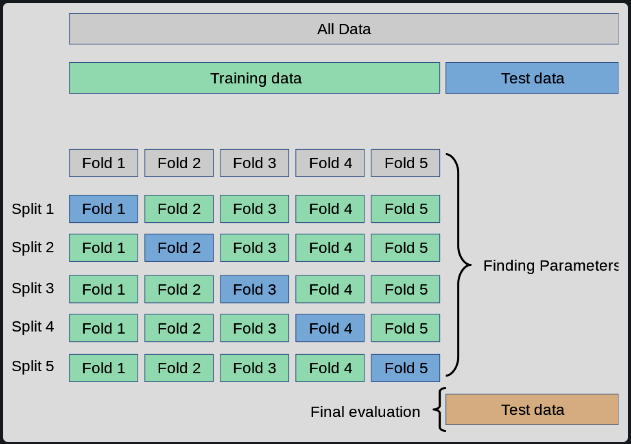

In [35]:
Image(filename='image/CV_scheme.png')

#### Pour se faciliter la tâche, on utilise GridSearchCV de sklearn.model_selection
#### On lui passe l'instance du modèle que l'on veut utiliser, les hyperparamètres à tester, le nombre de validations croisées à éffectuer et on obtient nos meilleurs hyperparamètres
#### On utilise généralement entre 5 et 10 validations croisées, mais là aussi il faut faire preuve de bon sens, en fonction de la taille du jeu de données, etc... 

# 2. **La validation croisée**
##    2. Recherche des meilleurs hyperparamètres de régularisation / Implémentation en python sous sklearn

#### Essayons de rechercher la meilleur valeur de alpha pour un modèle linéaire avec la régulation Lasso (L1)

In [47]:
#on ouvre la table USA_cars.csv
df = pd.read_csv('USA_cars.csv', index_col=0)
df

,price,mileage,model
0,5350,39590.0,mpv
1,25000,64146.0,door
2,5700,45561.0,mpv
3,13350,23525.0,door
4,5250,63418.0,mpv
...,...,...,...
1317,13900,44313.0,rogue
1318,13900,42502.0,rogue
1319,13900,41539.0,rogue
1320,13900,39924.0,rogue


#### On utilise un dataset de voitures usagers au USA, nous allons essayer de prédire le prix, en fonction du modèle et du kilométrage (mileage)

In [48]:
#on fait une matrice de corrélation
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,price,mileage
price,1.000000,-0.411824
mileage,-0.411824,1.000000


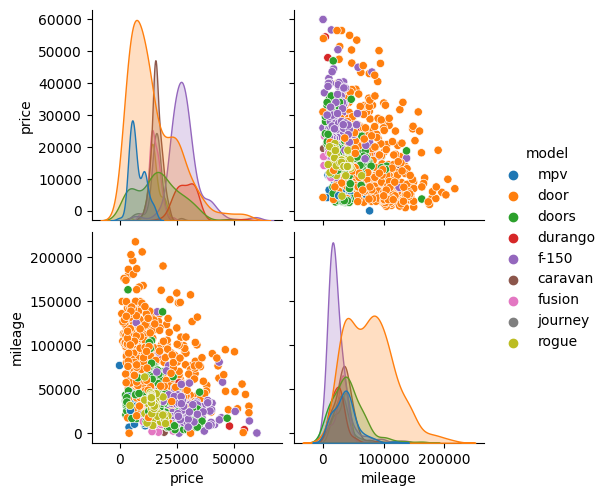

In [38]:
#on fait un pairplot pour voir les relations entre les variables et leurs distributions
sns.pairplot(df, hue = 'model')

#### Nous suivons les étapes suivantes pour l'entrainement d'un modèle de régression et pour évaluer si il **généralise** bien sur des données de test:
1. on sépare les variables explicatives (features >>> un dataframe ou array nommé X) de la variable à prédire (target >>> un dataframe ou array nommé y)
2. on rajoute une colonne avec une constante = 1, afin de permettre de calculer le paramètre de l'ordonnée à l'origine (e.g. intercept) 
3. on divise les données en deux parties, les données d'entrainement et les données de test
4. on crée une instance de la classe du modèle (ex: model = Lasso() pour une régression linéaire), on dit qu'on **initialise** le modèle
5. on ajuste (fit) le modèle avec les données d'entrainement (ex: model.fit(X_train, y_train))
6. on évalue l'erreur produite par le modèle sur les données d'entrainement et de test en utilisant le coéfficient de détermination R2 (ex: model.score(X_train, y_train); model.score(X_test, y_test)) et on compare la différence, si il n'y a pas de différence entre les R2 (train et test) le modèle généralise bien, et c'est cela que l'on cherche
7. on fait les vérifications vues dans le cours sur la régression linéaire (tracer la courbe du modèle sur les données, observed vs predicted, distribution des résidues, etc...)
8. on valide ou pas, on améliore, etc...

#### On a ici une variable categorielle, il faut donc transformer cette variable en colonne avec des 0 et des 1 (pandas.get_dummies) afin d'autoriser des intercepts pour chaque catégorie
#### On peut aussi utiliser la méthode OneHotEncoder de sklearn
#### On doit aussi autoriser différentes pentes et donc multiplier les colonnes créer avec get_dummies par la variable quantitative

In [39]:
#1. on sépare les variables explicatives (features >>> un dataframe ou array nommé X) de la variable à prédire (target >>> un dataframe ou array nommé y)
y = df[['price']]
X = df[['mileage', 'model']]
#2. on rajoute une colonne avec une constante = 1, afin de permettre de calculer le paramètre de l'ordonnée à l'origine (e.g. intercept) 
X['constant'] = 1
#on transforme la variable catégorielle model en variable numérique avec la méthode pandas get_dummies
X = pd.get_dummies(X)
#on crée une fonction pour itérer sur les noms des colonnes et ajouter les colonnes manquantes (mileage x colonne obtenue avec get_dummies)
#on créer d'abord une liste du nom des colonnes obtenue avec get_dummies (toutes sauf 'mileage' et 'constant')
dummies_col = [i for i in X.columns if i not in ['mileage', 'constant']]
#on itère sur la liste des colonnes obtenue avec get_dummies
for col in dummies_col:
    #on crée une colonne avec le produit de la colonne mileage et la colonne obtenue avec get_dummies
    X[col + '_x_mileage'] = X['mileage'] * X[col]
#on regarde les colonnes obtenues
X.head(10)

,mileage,constant,model_caravan,model_door,model_doors,model_durango,model_f-150,model_fusion,model_journey,model_mpv,model_rogue,model_caravan_x_mileage,model_door_x_mileage,model_doors_x_mileage,model_durango_x_mileage,model_f-150_x_mileage,model_fusion_x_mileage,model_journey_x_mileage,model_mpv_x_mileage,model_rogue_x_mileage
0,39590.0,1,0,0,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39590.0,0.0
1,64146.0,1,0,1,0,0,0,0,0,0,0,0.0,64146.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,45561.0,1,0,0,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45561.0,0.0
3,23525.0,1,0,1,0,0,0,0,0,0,0,0.0,23525.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,63418.0,1,0,0,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63418.0,0.0
5,39650.0,1,0,0,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39650.0,0.0
6,100757.0,1,0,1,0,0,0,0,0,0,0,0.0,100757.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,25747.0,1,0,1,0,0,0,0,0,0,0,0.0,25747.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,35714.0,1,0,0,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35714.0,0.0
9,54380.0,1,0,1,0,0,0,0,0,0,0,0.0,54380.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 3. on sépare les données en deux parties, les données d'entrainement et les données de test avec les proportions (80%-20%)

In [40]:
#3. on sépare les données en deux parties, les données d'entrainement et les données de test avec les proportions (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
# on regarde les dimensions des données d'entrainement
X_train.shape

(1057, 20)

In [42]:
#on regarde les dimensions des données de test
X_test.shape

(265, 20)

#### 4. on crée une instance de la classe du modèle (ex: model = Lasso() pour une régression linéaire), on dit qu'on **initialise** le modèle
#### 5. on ajuste (fit) le modèle avec les données d'entrainement (ex: model.fit(X_train, y_train))
#### !!!Comme on l'a vu on utilise gridsearchCV pour faire la validation croisée et trouver le meilleur hyperparamètre alpha de régularisation!!!

In [43]:
from sklearn.model_selection import GridSearchCV
#on recherche les meilleurs paramètres pour un modèle Lasso
#on initialise le modèle Lasso
lasso = Lasso()
#on crée un dictionnaire avec les paramètres à tester
param_grid = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
#on crée un objet de la classe GridSearchCV dans lequel on met le modèle Lasso et le dictionnaire de paramètres, et le nombre de divisions du dataset pour la validation croisée
#ici on utilise 3 divisions car on a peu de données, mais généralement on utilise 5 ou 10 divisions si on a beaucoup de données
grid_search = GridSearchCV(lasso, param_grid, cv=5)
#on entraine le modèle sur les données d'entrainement
grid_search.fit(X_train, y_train['price'])
#on affiche le résultat de la recherche des meilleurs paramètres
print(grid_search.cv_results_)
#on affiche les meilleurs paramètres
print(grid_search.best_params_)
#on affiche le meilleur score pour le modèle
print(grid_search.best_score_)

{'mean_fit_time': array([0.01840458, 0.01738129, 0.01813636, 0.01870704, 0.01939788,
       0.01516891, 0.00919838, 0.00312276, 0.01545744]), 'std_fit_time': array([0.00324708, 0.00042922, 0.00095392, 0.00142938, 0.00098776,
       0.00046609, 0.00474789, 0.00046271, 0.00159085]), 'mean_score_time': array([0.00163755, 0.00149436, 0.00156522, 0.00172834, 0.00169783,
       0.00163321, 0.00154386, 0.00146341, 0.00182891]), 'std_score_time': array([1.69911847e-04, 3.42428845e-05, 9.98525929e-05, 2.75914742e-04,
       1.41318751e-04, 6.18203147e-05, 7.27011083e-05, 4.68308956e-05,
       6.92528648e-04]), 'param_alpha': masked_array(data=[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'params': [{'alpha': 1e-05}, {'alpha': 0.0001}, {'alpha': 0.001}, {'alpha': 0.01}, {'alpha': 0.1}, {'alpha': 1}, {'alpha': 10}, {'alpha': 100}, {'alpha'

#### 6. on évalue l'erreur produite par le modèle sur les données d'entrainement et de test en utilisant le coéfficient de détermination R2 (ex: model.score(X_train, y_train); model.score(X_test, y_test)) et on compare la différence, si il n'y a pas de différence entre les R2 (train et test) le modèle généralise bien, et c'est cela que l'on cherche

In [44]:
#on entraine le modèle avec les meilleurs paramètres
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train['price'])
#on ajoute les prédictions du modèle à nos dataframe de training et de test
y_train['pred_reg'] = lasso.predict(X_train)
y_test['pred_reg'] = lasso.predict(X_test)
#on calcule le coefficient de détermination R2 avec la méthode .score
R2_train = lasso.score(X_train, y_train['price'])
R2_test = lasso.score(X_test, y_test['price'])
print(f'Le R2 score de d\'entrainement est de {round(R2_train,2)}')
print(f'Le R2 score de test est de {round(R2_test,2)}')

Le R2 score de d'entrainement est de 0.42
Le R2 score de test est de 0.44


#### On observe des R2 similaire pour les données d'entrainement et les données de test!!!

#### 7. on fait les vérifications vues dans le cours sur la régression linéaire (tracer la courbe du modèle sur les données, observed vs predicted, distribution des résidues, etc...)

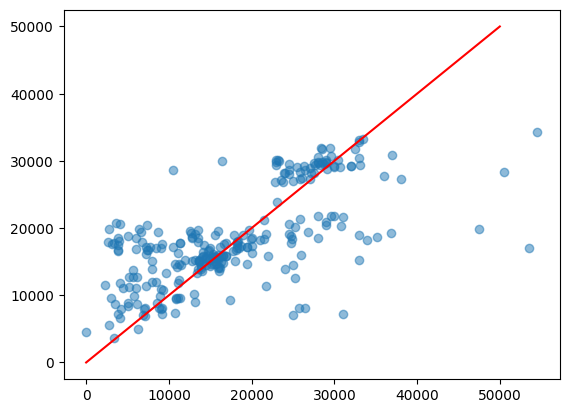

In [45]:
#on fait un graphique des valeurs prédites et des valeurs réelles sur les données de test
plt.scatter(y_test['price'], y_test['pred_reg'], alpha=0.5)
#on ajuste la droite 1:1
plt.plot([0, 50000], [0, 50000], c='r')

#### On voit que l'on arrive à prédire correctement certains prix mais la répartition des prédictions ne suit pas totalement la ligne 1:1, et il y a des paquets, probablement de bonnes et de mauvaises prédictions pour certains types de voitures
#### Regardons les droites de régression par type de voitures

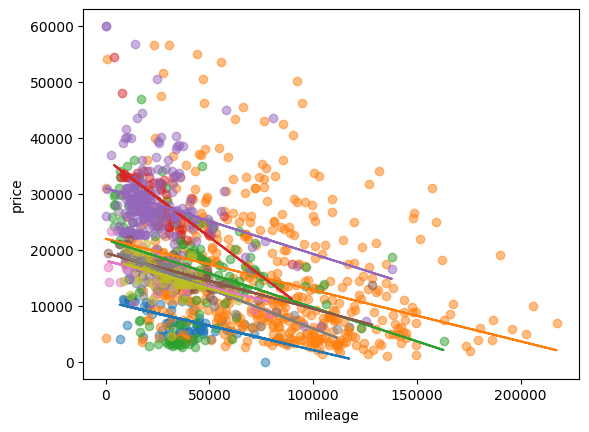

In [46]:
#on regarde les régression de manière graphique et par "model" de voiture
#on crée une liste des modèles de voiture
models = df['model'].unique()
#on crée un graphique avec les régressions pour chaque modèle
for model in models:
    #on sélectionne les données pour le modèle
    df_model = df[df['model'] == model]
    #on sépare les variables explicatives (features) et la variable à prédire (target)
    y = df_model[['price']]
    X = df_model[['mileage']]
    #on rajoute une colonne avec une constante = 1, afin de permettre de calculer le paramètre de l'ordonnée à l'origine (e.g. intercept)
    X['constant'] = 1
    #on crée un objet de la classe LinearRegression, on initialise le modèle
    model = LinearRegression()
    #on entraine le modèle sur les données
    model.fit(X, y)
    #on ajoute les prédictions du modèle à nos dataframe
    y['pred'] = model.predict(X)
    #on fait un graphique avec les régressions
    plt.scatter(X['mileage'], y['price'], label=model, alpha=0.5)
    plt.plot(X['mileage'], y['pred'], label=model)
    plt.xlabel('mileage')
    plt.ylabel('price')

#### On voit que les données sont très dispersées pour certains modèles, et que le problème est probablement plus complexe.
#### Il nous faudrait d'autres features comme l'état de la voiture, l'année, etc... afin de mieux prédire (c'est néanmoins à tester).
#### Peut-être faudrait-il aussi un autre type de modèle pour résoudre ce problème.
#### Peut-être que le prix est impossible à prédire précisemment car il dépend de trop de facteurs difficile à déterminer (ex: psychologie de l'acheteur), qui peuvent biaiser notre dataset. 
#### L'important ici est que vous ayez compris les concepts sous-jacents à l'entrainement d'un modèle linéaire et que vous soyez capable de les mettre en action.


# **Conclusions**
### Il est extrêmenent important que le modèle soit capable de **généraliser sur des données qu'il n'a pas vu pendant l'entrainement**. 
### Pour évaluer cela, on divise le dataset en **données d'entrainement et de test**.
### La **régularisation** (Lasso, Ridge) permet de limiter le **sur-apprentissage (overfitting)** en ajoutant une **pénalité sur les paramètres du modèle**.
### On utilise la **validation croisée** pour trouver les **meilleurs paramètres de régularisation** du modèle pendant l'apprentissage.